# K Means Clustring

The purpose of this notebook is to give you a sense of whats happening when you use an algorithm from sklearn, and hopefully covey how you can learn more by trying to implement them yourself.  With K-Mean means the goal is to seperate our examples in $ k $ clusters $ C = \{C_1,C_2,...,C_k \} $. 


# Algorithm

The way the algorithm works is as follows.

1. Randomly pick $ k $ points as our cluster centers, these points are called centroids
2. Assgin each $ x_i $ to the closest centroid based on euclidean distance, to create a cluster.
3. Take the mean of all points assigned to a cluster to calculate new centroid.
4. Repeat step 2 and 3 until none of the centorids move or we pass the iteration limit.


Mathematically by performing this algorithm we are minimizing the following equation with respect to $ C_k $ and $ \mu_k $:

$$ \displaystyle \sum_{k=1}^K \sum_{\mathrm{x}_n \in C_k} ||\mathrm{x}_n - \mu_k||^2 $$

* $ C = \{C_1,C_2,...,C_k \} $ is the set of clusters 
* $ \mu_k $ is the centroid, this is calculated by taking the mean of all of the point a cluster$ C_k $.
* $ x_n $ is a data point.
* $ || $ is eucldiean distance.

You may notice the similarity with the equation for variance which is:

$$ \frac{1}{N} \sum_{i=1}^{N}  (x_i - \mu)^2 $$

And we are in fact trying to minmize the variance within each of the $ K $ clusters, helping us to create coherent clusters.

# Data

We'll use sklearn to generate some dummy data for us.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [19]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=1000, centers=3, n_features=2,cluster_std = 0.7 , random_state=0)

In [20]:
X.shape #1000 for number of examples, 2 for dimentiality of data points 

(1000, 2)

In [21]:
y.shape #1000 contains the label for each point

(1000,)

In [22]:
plt.scatter(X[:,0],X[:,1])

# Inizialize

We need to pick points for our centroids to initialize the algorithm, there's a few ways to do this but we'll settle for the simplest randomly picking $ k $ points from our dataset.

In [23]:
def random_centroids(X,k):
    """
    Randomly pick K points for our centroids, returns a matrix
    of shape K by N. Where each row represent a centroid.
    """
    return X[np.random.choice(X.shape[0], k), :]

# Assignment

For this stage we need to calculate the eucldiean distance between each point and each centroid. We then assign each point to the cluster with the closest centroid.

$$ \displaystyle C_k = \{\mathrm{x}_n : ||\mathrm{x}_n - \mu_k|| \leq \mathrm{\,\,all\,\,} ||\mathrm{x}_n - \mu_l||\} $$

More fomally the above equation is saying that the $k$th cluster $ C_k $ is the set of all point for which eucldiean distance between $ x_n $ and the $ \mu_k $ is the smallest. 

In [24]:
def closest_centroids(X,centroids):
    
    """
    Calculate the closest centroid for each point by calculating
    the eucldian distance and return a label for each centroid
    """
    distance = np.array([ np.sum((X-centroid)**2,axis=1) for centroid in centroids ])
    return distance.argmin(axis=0)

# Update

To update the centroid we take the mean of all points in it's cluster.


$$ c_{k}^{(t+1)}={\frac {1}{|C_{k}^{(t)}|}}\sum _{x_{i}\in C_{k}^{(t)}}x_{i} $$




In [25]:
def calc_new_centroids(X,labels,k):
    """
    labels = the old centroid
    Calculates the new centroids based on the average of each axis.
    Let the new centroid be the mean of each column (representing each centroid) 
    """
    return np.array([ X[labels == k ].mean(axis=0) for k in range(k)])

In [26]:
# Examples
# x = np.arange(0,12).reshape(4,3)
# x.mean(axis = 0).shape

# Should stop

Under two circumstances should the algorithm stop:

* It's converged meaning the centroids are no longer moving
* We've passed the number of iterations


In [30]:
def should_stop(old_centroids,new_centroids,current_iter,max_iters = 10):
    
    if current_iter > max_iters: return True
    return np.all(old_centroids == new_centroids)

# Altogether 

We've broken down the algo it small parts now lets piece it altogether for our final implementation. 


In [31]:
def kmeans(X,k,max_iters =100):
    
    centroids = random_centroids(X,k)
    labels = old_centroids = None
    iteration = 1
    
    while not should_stop(old_centroids,centroids,iteration,max_iters):
        labels = closest_centroids(X,centroids)
        old_centroids = centroids
        centroids = calc_new_centroids(X,labels,k)
        iteration += 1
    return centroids, labels

In [32]:
k = 3
centroids,labels = kmeans(X,k)

for i,color in zip(range(k),['r','b','g']):
    d = X[labels == i]
    plt.scatter(d[:,0],d[:,1],color= color)

/Users/andy/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  after removing the cwd from sys.path.


# Double Check

Now that we've implemented our algorithm lets double check it against sklearn.

In [36]:
from sklearn.cluster import KMeans
%matplotlib inline

In [37]:
k = 3
#Sklearn version
kmeans_sk = KMeans(3,init='random')
kmeans_sk.fit(X)
pred_sk = kmeans_sk.predict(X)
#Our pred
centroids,pred_me = kmeans(X,k)

/Users/andy/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  after removing the cwd from sys.path.


In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels, pred_sk)

array([[  0,   0, 331],
       [  0, 332,   1],
       [336,   0,   0]])

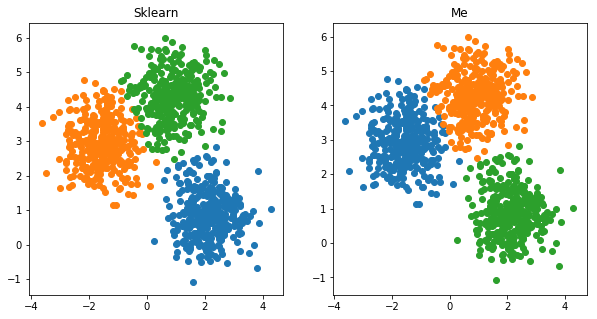

In [38]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(10,5)

for i,(title,pred) in enumerate(zip(["Sklearn","Me"],[pred_sk,pred_me])):
    for j in range(k):
        axes[i].scatter(X[pred == j,0],X[pred == j,1])
    axes[i].set_title(title)

# Choosing K

K means  is a little naive it will also find k-clusters even if this isn't the best number, so how do we know whats a good value to pick for k?  We can calculate the SSE for each point. The SSE is the sqaured distance between each point in a cluster and it's centroid.

In [18]:
X, y = make_blobs(n_samples=1000, centers=5, n_features=2,cluster_std = 0.7 , random_state=0)

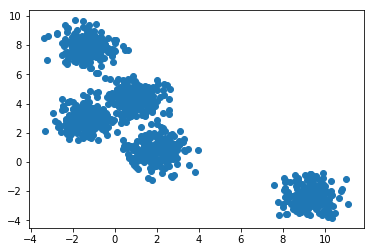

In [19]:
plt.scatter(X[:,0],X[:,1])

In [20]:
sse = []
for k in range(1,10):
    kmeans_sk = KMeans(n_clusters=k, max_iter=1000).fit(X)
    sse.append(kmeans_sk.inertia_)
    

Text(0,0.5,'SSE')

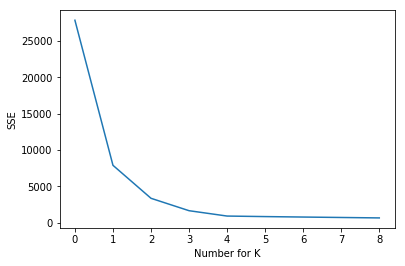

In [21]:
plt.plot(sse)
plt.xlabel("Number for K")
plt.ylabel("SSE")

The curve rapidly tapers off after 4.

# Use Cases

K-Means has many use cases for example:

* Document Classification - We can use K-means to cluster documents into multiple catergories based on tags, topics of the content of the document (by using word frequiences), however LDA may be more applicable here.
* Customer Segmentation - Clustering can be use to help markets by segmenting customers into groups.
* Detecting Fraud/Bots - When we cluster if we choose the correct features fradulant or bot like behaviour cluster together making it easier for us to identify.

For more usecases see [here](https://dzone.com/articles/10-interesting-use-cases-for-the-k-means-algorithm)

# References

* [K-Means Clsutering in Python](https://mubaris.com/2017/10/01/kmeans-clustering-in-python/)
* [K Means Blog Lyods](https://datasciencelab.wordpress.com/2013/12/12/clustering-with-k-means-in-python/)
* [Use Cases](https://dzone.com/articles/10-interesting-use-cases-for-the-k-means-algorithm)
* [K-Means Rosseta Code](https://rosettacode.org/wiki/K-means%2B%2B_clustering#Python)
* [K-Means Clustering - The Math of Intelligence](https://www.youtube.com/watch?v=9991JlKnFmk)

* [CS221 Kmeans](http://stanford.edu/~cpiech/cs221/handouts/kmeans.html)

In [8]:
import numpy as np
np.random.randint(0,10,size = (10,10))
#np.info(np.random.randint)

array([[1, 9, 1, 5, 4, 8, 3, 0, 0, 9],
       [2, 8, 0, 6, 2, 2, 0, 7, 6, 2],
       [3, 5, 6, 7, 3, 2, 9, 1, 4, 1],
       [6, 6, 4, 9, 2, 8, 8, 1, 1, 1],
       [6, 6, 8, 2, 4, 3, 3, 8, 5, 2],
       [5, 2, 6, 8, 6, 3, 7, 6, 6, 8],
       [2, 1, 2, 1, 7, 6, 3, 2, 5, 0],
       [4, 6, 3, 6, 9, 4, 9, 1, 1, 3],
       [5, 0, 6, 1, 3, 1, 2, 4, 6, 1],
       [7, 2, 3, 4, 7, 7, 6, 7, 8, 3]])

In [10]:
a = [1,2,3]
b = [4,5,6]
list(zip(a,b))

[(1, 4), (2, 5), (3, 6)]